Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [144]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.optimizers import Adam
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [145]:
# First unzip the file
# !unzip /content/drive/MyDrive/CNN_Assignment-Skin_Cancer/CNN_assignment.zip
# !ls

In [146]:
# Defining the path for training and test images

data_dir_train = pathlib.Path("/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [147]:
type(data_dir_train)

pathlib.PosixPath

In [148]:
# In total we have data is distributed in 9 classes/folder
list(data_dir_train.glob('*'))

[PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis'),
 PosixPath('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma')]

In [149]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [150]:
# Total images to train : 2239
# Total images to test : 118

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset

In [151]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [152]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # You can adjust the validation split as needed
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size  # Adjust batch size according to your system's memory
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


See how the train images looks like with classes

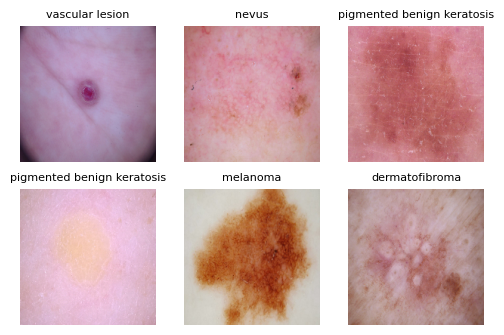

In [153]:
# Define a list of class names if available (optional)
class_names = train_ds.class_names

# Function to show images with labels
def show_images(dataset, num_images=6):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if class_names:
                plt.title(class_names[labels[i]], fontsize=8)
            plt.axis("off")
    plt.show()

# Display sample images from the validation_dataset
show_images(train_ds)

In [154]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


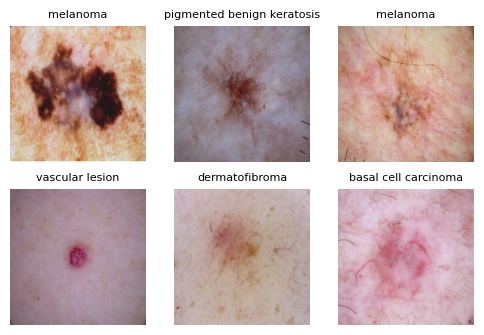

In [155]:
# Define a list of class names if available (optional)
class_names = val_ds.class_names

# Function to show images with labels
def show_images(dataset, num_images=6):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if class_names:
                plt.title(class_names[labels[i]], fontsize=8)
            plt.axis("off")
    plt.show()

# Display sample images from the validation_dataset
show_images(val_ds)

**Total no. of classes : 9**

In [156]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Visualize the data

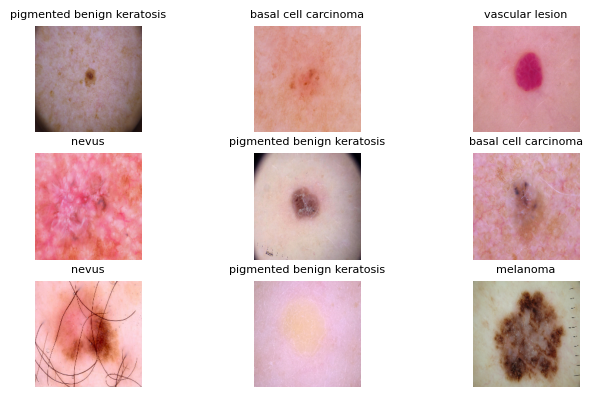

In [157]:
# Define a list of class names if available (optional)
class_names = train_ds.class_names

# Function to show images with labels
def show_images(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(5, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if class_names:
                plt.title(class_names[labels[i]], fontsize=8)
            plt.axis("off")
    plt.show()

# Display sample images from the validation_dataset
show_images(train_ds)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [158]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the Model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [161]:
num_classes = 9
num_channels = 3

train_images = []
train_labels = []

for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)

In [162]:
train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [163]:
print(len(train_images))
print(len(train_labels))

1792
1792


In [164]:
set(train_labels.numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [165]:
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images)
    val_labels.append(labels)

In [166]:
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

In [167]:
print(len(val_images))
print(len(val_labels))

447
447


In [169]:
train_images.shape

TensorShape([1792, 180, 180, 3])

In [170]:
train_labels.shape

TensorShape([1792])

In [171]:
val_images.shape

TensorShape([447, 180, 180, 3])

In [172]:
val_labels.shape

TensorShape([447])

In [173]:
# Normalization

train_images = train_images / 255.0
val_images = val_images / 255.0

In [174]:
# Label Encoding

from keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels)
val_labels_encoded = to_categorical(val_labels)

Use Padding = 0 

In [175]:
# First create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding = 'same', input_shape=(img_height, img_width, num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [176]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [177]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_10 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_15 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_11 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                     

Train the model

In [178]:
epochs = 20
history = model.fit(
  train_images,
  train_labels_encoded,
  epochs=epochs,
  validation_data=(val_images, val_labels_encoded)
)

Epoch 1/20
56/56 [==============================] - 12s 155ms/step - loss: 34.7422 - accuracy: 0.2852 - val_loss: 28.5209 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 8s 147ms/step - loss: 3.3776 - accuracy: 0.2489 - val_loss: 227.7069 - val_accuracy: 0.0403
Epoch 3/20
56/56 [==============================] - 9s 154ms/step - loss: 2.1788 - accuracy: 0.2662 - val_loss: 278.5609 - val_accuracy: 0.0403
Epoch 4/20
56/56 [==============================] - 9s 155ms/step - loss: 2.0501 - accuracy: 0.2723 - val_loss: 264.8715 - val_accuracy: 0.0403
Epoch 5/20
56/56 [==============================] - 9s 153ms/step - loss: 2.0288 - accuracy: 0.2779 - val_loss: 250.2538 - val_accuracy: 0.0403
Epoch 6/20
56/56 [==============================] - 9s 155ms/step - loss: 2.0066 - accuracy: 0.2824 - val_loss: 154.9208 - val_accuracy: 0.0515
Epoch 7/20
56/56 [==============================] - 8s 147ms/step - loss: 1.9541 - accuracy: 0.3058 - val_loss: 114.8266 - val_accuracy

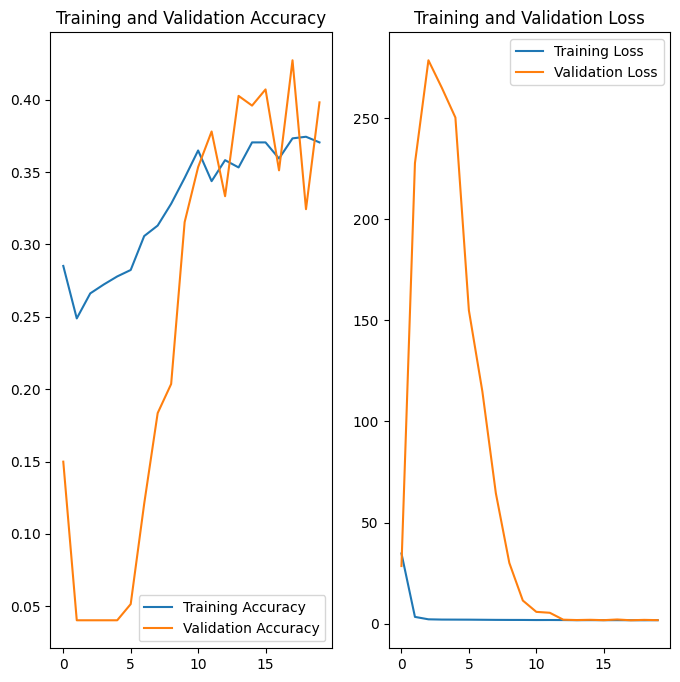

In [179]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [180]:
## We have very bad model here :
# having training accuracy: 0.3393 and val_accuracy: 0.3356 which is not good at all

Findings from 1st Model :
- Training accuracy: **0.3705**
- Validation accuracy: **0.3982**
- Our Model is clearly **underfit** because our training and testing accuracy is **too low**.
- Create 2nd Model by changing the epoch value and some changes in the layers also




---



## 2nd Attempt to try our model Best

In [181]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [182]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [183]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_14 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_21 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_15 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                     

In [184]:
epochs = 30
history = model.fit(
  train_images,
  train_labels_encoded,
  epochs=epochs,
  validation_data=(val_images, val_labels_encoded)
)

Epoch 1/30
56/56 [==============================] - 15s 171ms/step - loss: 21.0026 - accuracy: 0.2645 - val_loss: 4.1754 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 9s 165ms/step - loss: 4.9988 - accuracy: 0.2757 - val_loss: 35.4677 - val_accuracy: 0.0492
Epoch 3/30
56/56 [==============================] - 9s 165ms/step - loss: 2.4159 - accuracy: 0.2640 - val_loss: 40.2261 - val_accuracy: 0.0492
Epoch 4/30
56/56 [==============================] - 9s 169ms/step - loss: 1.9927 - accuracy: 0.2913 - val_loss: 53.4596 - val_accuracy: 0.0492
Epoch 5/30
56/56 [==============================] - 9s 168ms/step - loss: 1.8511 - accuracy: 0.3588 - val_loss: 46.9486 - val_accuracy: 0.0515
Epoch 6/30
56/56 [==============================] - 9s 169ms/step - loss: 1.8441 - accuracy: 0.3811 - val_loss: 17.5986 - val_accuracy: 0.1275
Epoch 7/30
56/56 [==============================] - 10s 170ms/step - loss: 1.7863 - accuracy: 0.4085 - val_loss: 36.8416 - val_accuracy: 0.12

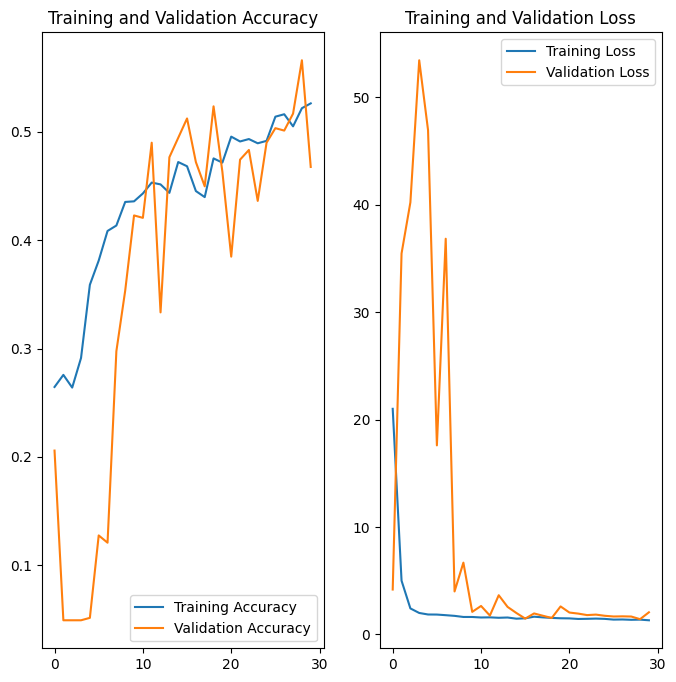

In [185]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings from 2nd Model 2nd Time with **30** epochs and having different layers :
- Training Accuracy : **0.5262**
- Validation Accuracy : **0.4676**
- Since the difference between these two accuracy is very high, we can say that model is **Overfit**
- Validation Loss is increasing in start of the epochs but later it will go steadily, but loss is still high
- **We cannot consider this Model**
- Need to research more



---



---



Need to check why the accuracy is not good
- Checking the num. of classes in each category
- Might be the case of Class Imbalance

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [207]:
train_labels.shape

TensorShape([1792])

In [208]:
class_counts = {}  # Initialize an empty dictionary

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

In [209]:
class_counts

{1: 309, 7: 142, 0: 92, 6: 58, 5: 370, 4: 277, 2: 77, 3: 352, 8: 115}

In [210]:
# Access the count of samples for each class
for class_idx, class_count in class_counts.items():
    class_name = class_names[class_idx]  # Assuming class_names is a list of class names
    print(f"Class {class_name}: {class_count} samples")


Class basal cell carcinoma: 309 samples
Class squamous cell carcinoma: 142 samples
Class actinic keratosis: 92 samples
Class seborrheic keratosis: 58 samples
Class pigmented benign keratosis: 370 samples
Class nevus: 277 samples
Class dermatofibroma: 77 samples
Class melanoma: 352 samples
Class vascular lesion: 115 samples


In [211]:
# Dominate classes
total_samples = sum(class_counts.values())

# Calculate the proportions and find the dominating classes
dominating_classes = []
for class_idx, class_count in class_counts.items():
    class_name = class_names[class_idx]
    class_proportion = class_count / total_samples
    print(f"Class {class_name}: {class_count} samples ({class_proportion:.2%} proportion)")

    # If the proportion is above a certain threshold (e.g., 10%)
    if class_proportion > 0.10:
        dominating_classes.append(class_name)

print("\nDominating classes:", dominating_classes)

Class basal cell carcinoma: 309 samples (17.24% proportion)
Class squamous cell carcinoma: 142 samples (7.92% proportion)
Class actinic keratosis: 92 samples (5.13% proportion)
Class seborrheic keratosis: 58 samples (3.24% proportion)
Class pigmented benign keratosis: 370 samples (20.65% proportion)
Class nevus: 277 samples (15.46% proportion)
Class dermatofibroma: 77 samples (4.30% proportion)
Class melanoma: 352 samples (19.64% proportion)
Class vascular lesion: 115 samples (6.42% proportion)

Dominating classes: ['basal cell carcinoma', 'pigmented benign keratosis', 'nevus', 'melanoma']


Findings :
- Class having least no. of samples : **seborrheic keratosis**
- Dominating classes: ['pigmented benign keratosis', 'basal cell carcinoma', 'nevus', 'melanoma']



---



---



Rectify the Class Imbalance using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


Augmentor

In [195]:
!pip install Augmentor

In [196]:
import Augmentor

In [217]:
import os

# Specify the main data directory
main_data_directory = "/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train"

# List of class names based on the subdirectory names in the main data directory
class_names = sorted(os.listdir(main_data_directory))

# Specify the output directory where augmented images will be saved
output_base_directory = "/content/Augmented_Output/Train"

# Loop through each class and perform augmentation
for class_name in class_names:
    # Construct paths for the current class
    class_data_directory = os.path.join(main_data_directory, class_name)
    class_output_directory = os.path.join(output_base_directory, class_name)

    # Create the augmentation pipeline
    p = Augmentor.Pipeline(source_directory=class_data_directory, output_directory=class_output_directory)

    # Define augmentation operations (e.g., rotation, flipping, etc.)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # p.flip_left_right(probability=0.5)
    # p.zoom_random(probability=0.5, percentage_area=0.8)
    # Add more operations as needed

    # Specify the desired number of augmented samples per class
    num_samples_per_class = 500

    # Execute the augmentation operations
    p.sample(num_samples_per_class)


Initialised with 114 image(s) found.
Output directory set to /content/Augmented_Output/Train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5E3F87610>: 100%|██████████| 500/500 [00:15<00:00, 31.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Augmented_Output/Train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD656629F00>: 100%|██████████| 500/500 [00:15<00:00, 32.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Augmented_Output/Train/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD635A20790>: 100%|██████████| 500/500 [00:15<00:00, 31.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Augmented_Output/Train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD5B4DF12D0>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Augmented_Output/Train/nevus.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD6395C2500>: 100%|██████████| 500/500 [01:16<00:00,  6.53 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Augmented_Output/Train/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5C0549870>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Augmented_Output/Train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD5B4DC2BC0>: 100%|██████████| 500/500 [00:38<00:00, 12.87 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Augmented_Output/Train/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD656629E70>: 100%|██████████| 500/500 [00:14<00:00, 33.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Augmented_Output/Train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5D1BA6170>: 100%|██████████| 500/500 [00:15<00:00, 32.96 Samples/s]


Images present in Augmented Directory

In [220]:
data_dir_train = pathlib.Path("/content/Augmented_Output/Train")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


Images present in Original Directory

In [223]:
data_dir_train_org = pathlib.Path("/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
image_count_train_org = len(list(data_dir_train_org.glob('*/*.jpg')))
print(image_count_train_org)

2239


Now we need to add 500 images in each classes belongs to them
Join **image_count_train** and image_count_train_org

In [224]:
import os
import shutil
import pathlib

# Specify paths to augmented and original data directories
augmented_data_dir = pathlib.Path("/content/Augmented_Output/Train")
original_data_dir = pathlib.Path("/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")

# List of class names based on the subdirectory names in the augmented data directory
class_names = sorted(os.listdir(augmented_data_dir))

# Iterate through each class and copy augmented images to the original dataset
for class_name in class_names:
    augmented_class_dir = augmented_data_dir / class_name

    # Get the corresponding class directory in the original dataset
    original_class_dir = original_data_dir / class_name

    # Make sure the target directory exists
    if not original_class_dir.exists():
        original_class_dir.mkdir(parents=True)

    # Iterate through augmented images and copy them to the original class directory
    for image_file in augmented_class_dir.iterdir():
        if image_file.is_file():
            shutil.copy(image_file, original_class_dir)


In [225]:
data_dir_train_org = pathlib.Path("/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
image_count_train_org = len(list(data_dir_train_org.glob('*/*.jpg')))
print(image_count_train_org)

6739


Now we have total 6739 images to train our model
Let's apply the model Building process again



---



---



In [226]:
data_dir_train = pathlib.Path("/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [227]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

6739
118


In [228]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180
seed = 123

In [229]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # You can adjust the validation split as needed
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size  # Adjust batch size according to your system's memory
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [230]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [231]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [232]:
num_classes = 9
num_channels = 3

train_images = []
train_labels = []

for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)

In [233]:
train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [234]:
print(len(train_images))
print(len(train_labels))

5392
5392


In [235]:
set(train_labels.numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [236]:
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images)
    val_labels.append(labels)

In [237]:
val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

In [238]:
print(len(val_images))
print(len(val_labels))

1347
1347


In [239]:
# Normalization

train_images = train_images / 255.0
val_images = val_images / 255.0

# Label Encoding

from keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels)
val_labels_encoded = to_categorical(val_labels)

Attempt 1st Model

In [240]:
# First create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding = 'same', input_shape=(img_height, img_width, num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [241]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [242]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_28 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_20 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_29 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_21 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                     

In [244]:
epochs = 40
history = model.fit(
  train_images,
  train_labels_encoded,
  epochs=epochs,
  validation_data=(val_images, val_labels_encoded)
)

Epoch 1/40
169/169 [==============================] - 25s 147ms/step - loss: 2.1738 - accuracy: 0.1586 - val_loss: 2.1797 - val_accuracy: 0.1566
Epoch 2/40
169/169 [==============================] - 25s 147ms/step - loss: 2.1733 - accuracy: 0.1463 - val_loss: 2.1795 - val_accuracy: 0.1440
Epoch 3/40
169/169 [==============================] - 25s 146ms/step - loss: 2.1773 - accuracy: 0.1465 - val_loss: 2.1844 - val_accuracy: 0.1455
Epoch 4/40
169/169 [==============================] - 25s 148ms/step - loss: 2.1762 - accuracy: 0.1456 - val_loss: 2.1860 - val_accuracy: 0.1559
Epoch 5/40
169/169 [==============================] - 25s 148ms/step - loss: 2.1865 - accuracy: 0.1474 - val_loss: 2.1817 - val_accuracy: 0.1507
Epoch 6/40
169/169 [==============================] - 25s 148ms/step - loss: 2.1806 - accuracy: 0.1480 - val_loss: 2.1803 - val_accuracy: 0.1455
Epoch 7/40
169/169 [==============================] - 25s 147ms/step - loss: 2.1741 - accuracy: 0.1452 - val_loss: 2.1793 - val_ac

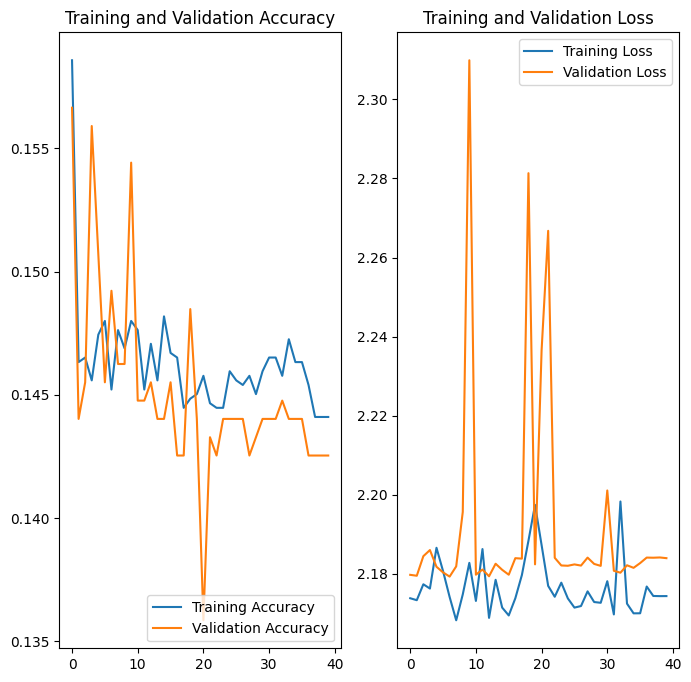

In [245]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Underfit Model



---



---



Attempt 2nd Model

In [246]:
# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [247]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [248]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_34 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_24 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_35 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_25 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                     

In [249]:
epochs = 50
history = model.fit(
  train_images,
  train_labels_encoded,
  epochs=epochs,
  validation_data=(val_images, val_labels_encoded)
)

Epoch 1/50
169/169 [==============================] - 36s 174ms/step - loss: 8.9987 - accuracy: 0.2281 - val_loss: 36.5010 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 27s 161ms/step - loss: 1.9832 - accuracy: 0.2557 - val_loss: 30.6565 - val_accuracy: 0.0943
Epoch 3/50
169/169 [==============================] - 27s 161ms/step - loss: 1.9510 - accuracy: 0.2533 - val_loss: 15.2362 - val_accuracy: 0.2049
Epoch 4/50
169/169 [==============================] - 27s 162ms/step - loss: 1.8678 - accuracy: 0.2854 - val_loss: 1.8395 - val_accuracy: 0.3734
Epoch 5/50
169/169 [==============================] - 27s 161ms/step - loss: 1.8465 - accuracy: 0.2904 - val_loss: 2.5945 - val_accuracy: 0.3363
Epoch 6/50
169/169 [==============================] - 27s 162ms/step - loss: 1.8275 - accuracy: 0.2880 - val_loss: 1.8965 - val_accuracy: 0.3192
Epoch 7/50
169/169 [==============================] - 27s 161ms/step - loss: 1.7896 - accuracy: 0.3080 - val_loss: 1.5700 - val

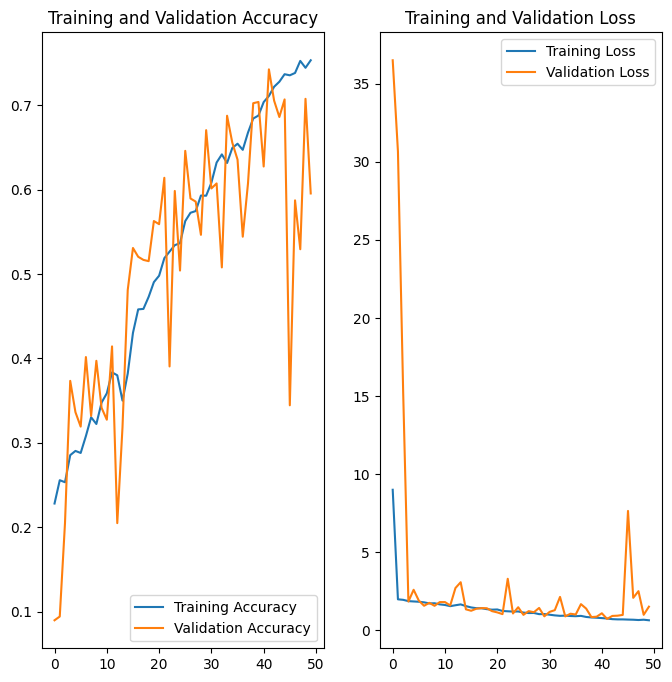

In [250]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfit Model



---



---



Attempt 3rd Model

In [263]:
from tensorflow.keras.regularizers import l2
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [264]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [265]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_58 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_42 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_43 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_59 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_43 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                    

In [266]:
epochs = 20
history = model.fit(
  train_images,
  train_labels_encoded,
  epochs=epochs,
  validation_data=(val_images, val_labels_encoded)
)

Epoch 1/20
169/169 [==============================] - 27s 152ms/step - loss: 14.0419 - accuracy: 0.3249 - val_loss: 15.6800 - val_accuracy: 0.1396
Epoch 2/20
169/169 [==============================] - 25s 149ms/step - loss: 10.9235 - accuracy: 0.4798 - val_loss: 12.7301 - val_accuracy: 0.3170
Epoch 3/20
169/169 [==============================] - 25s 148ms/step - loss: 10.1019 - accuracy: 0.5653 - val_loss: 10.0835 - val_accuracy: 0.5137
Epoch 4/20
169/169 [==============================] - 25s 150ms/step - loss: 9.3798 - accuracy: 0.6243 - val_loss: 9.3689 - val_accuracy: 0.5909
Epoch 5/20
169/169 [==============================] - 25s 149ms/step - loss: 8.7183 - accuracy: 0.6825 - val_loss: 9.5100 - val_accuracy: 0.5301
Epoch 6/20
169/169 [==============================] - 25s 150ms/step - loss: 8.1548 - accuracy: 0.7159 - val_loss: 8.0723 - val_accuracy: 0.6986
Epoch 7/20
169/169 [==============================] - 25s 150ms/step - loss: 7.6144 - accuracy: 0.7539 - val_loss: 7.7891 - 

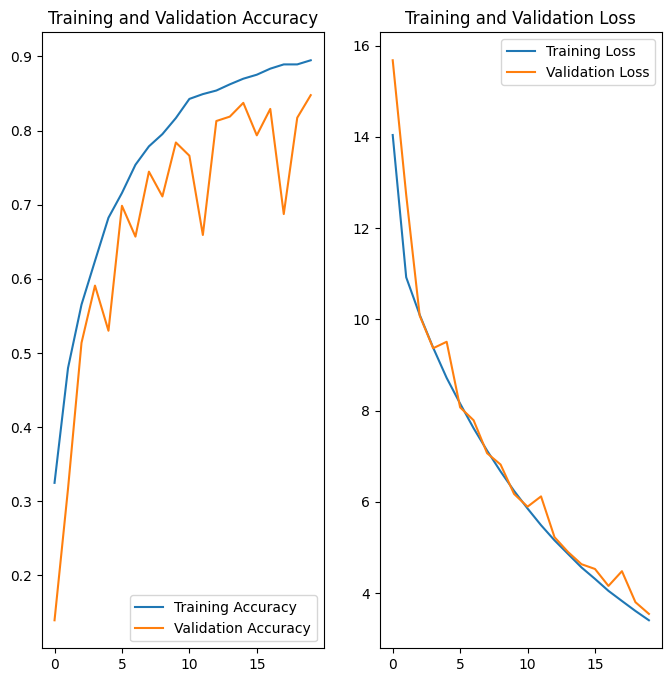

In [267]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Final Model Findings :
- Good Model having Training accuracy : **0.8948** and Validation Accuracy : **0.8478**
- Yes, i get rid of overfitting and underfitting, now my model is fine
- Yes, class imablance technique helped me to resolve the issue


# Thanks !!